## Anomaly Detection and Condition Monitoring

In this notebook, we will use machine learning and statistical analysis approaches to solve a specific use case for anomaly detection and condition monitoring.

Condition monitoring (CM) is the process of monitoring a parameter of condition in machinery (vibration, temperature etc.), in order to identify a significant change which is indicative of a developing fault. The use of CM allows maintenance to be scheduled, or other actions to be taken to prevent consequential damages and avoid its consequences. This could prevent shorterning of normal lifespan of equipments. 

CM techniques are normally used on rotating equipment, auxiliary systems and other machinery (compressors, pumps, electric motors, internal combustion engines, presses). 

In this notebook, we use CM on four bearings mounted on a shaft. The rotation speed was kept constant at 2000 RPM by an AC motor coupled to the shaft via rub belts as shown in Figure 1. A radial load of 6000 lbs is applied onto the shaft and bearing by a spring mechanism. All bearings are force lubricated.

Rexnord ZA-2115 double row bearings were installed on the shaft. PCB 353B33 High Sensitivity Quartz ICP accelerometers were installed on the bearing housing (one accelerometer for each bearing for data set). Sensor placement is also shown in Figure 1. All failures occurred after exceeding designed life time of the bearing which is more than 100 million revolutions.

In [250]:
import os
import cv2
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import lag_plot
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller

from tensorflow import keras
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers
print('All libraries imported successfully')

All libraries imported successfully


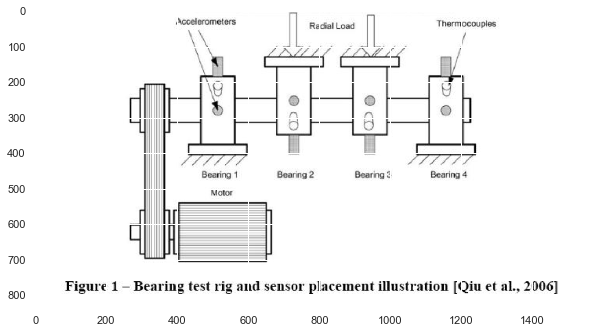

In [253]:
img=cv2.imread('bearing_photo.png')
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

### Data Analysis

An assumption is that gear degradation occur gradually over time, so we use one datapoint every 10 minutes in the following analysis. Each 10 minute datapoint is aggregated by using the mean absolute value of the vibration recordings over the 20,480 datapoints in each file. We then merge together everything in a single dataframe.

After loading the vibration data, we transform the index to datetime format, and then sort the data by index in chronological order. As we do not have the labels for the timestamps, this is an unsupervised learning task. 

In [213]:
data_dir = '2nd_test'
merged_data = pd.DataFrame()

for filename in os.listdir(data_dir):
    dataset=pd.read_csv(os.path.join(data_dir, filename), sep='\t')
    dataset_mean_abs = np.array(dataset.abs().mean())
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
    dataset_mean_abs.index = [filename]
    merged_data = merged_data.append(dataset_mean_abs)

cols=['Bearing 1','Bearing 2','Bearing 3','Bearing 4']
merged_data.columns = cols
merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
merged_data.index=pd.DatetimeIndex(merged_data.index)
merged_data = merged_data.sort_index()
merged_data.head(10)

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172
2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659
2004-02-12 11:42:39,0.061231,0.074172,0.082022,0.043840
2004-02-12 11:52:39,0.062280,0.075808,0.084372,0.044272
2004-02-12 12:02:39,0.059890,0.075115,0.084506,0.043974


In [6]:
# Dataset Shape
merged_data.shape

(984, 4)

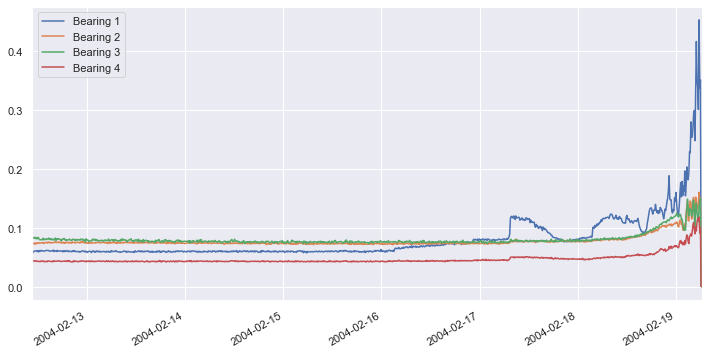

In [5]:
plt.figure(figsize=(12,6));
for col in merged_data.columns:
    merged_data.iloc[:][col].plot();
plt.legend();

Outer race failure occurred in Bearing 1 as per the information provided in the data. Other bearings did not fail but as seen from the plot above, exhibit erratic behavior. We shall strive to find anomalous behavior in the data above. 

In [8]:
merged_data.describe()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
count,984.000000,984.000000,984.000000,984.000000
mean,0.080905,0.078532,0.081356,0.047822
std,0.040171,0.011779,0.011596,0.009541
min,0.001168,0.000767,0.000716,0.001699
25%,0.060765,0.074233,0.076832,0.043950
50%,0.062007,0.075203,0.078197,0.044524
75%,0.083223,0.077456,0.080600,0.048111
max,0.453335,0.161016,0.151299,0.119047


Let's have a graphical view of the dataset

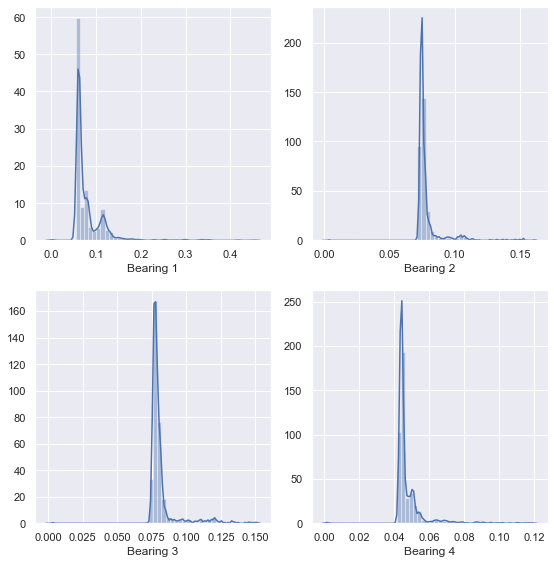

In [179]:
f, axes = plt.subplots(2, 2, figsize=(8, 8));
sns.distplot(merged_data['Bearing 1'],ax=axes[0,0]);
sns.distplot(merged_data['Bearing 2'],ax=axes[0,1]);
sns.distplot(merged_data['Bearing 3'],ax=axes[1,0]);
sns.distplot(merged_data['Bearing 4'],ax=axes[1,1]);
f.tight_layout()

We observe that the standard deviation of each series is very small, suggesting that the data is within a small range and very predictible. Each series contains some outliers as we see the distribution is left skewed for all bearings. These outlier values constitute non-anomalous behavior or errors in the sensor reading.

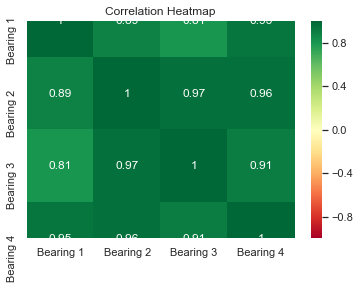

In [12]:
plt.figure()
corr = merged_data.corr()
corr.index = merged_data.columns
sns.heatmap(corr, annot = True, cmap='RdYlGn', vmin=-1, vmax=1)
plt.title("Correlation Heatmap", fontsize=12)
plt.show()

This high correlation amongst the columns is expected as the 4 bearings are connected on the same shaft. Therefore the value is for common motion of the shaft but recorded through 4 different accelerometers. From the below figures, the positive trend between the bearings confirms our analysis. 

<Figure size 432x288 with 0 Axes>

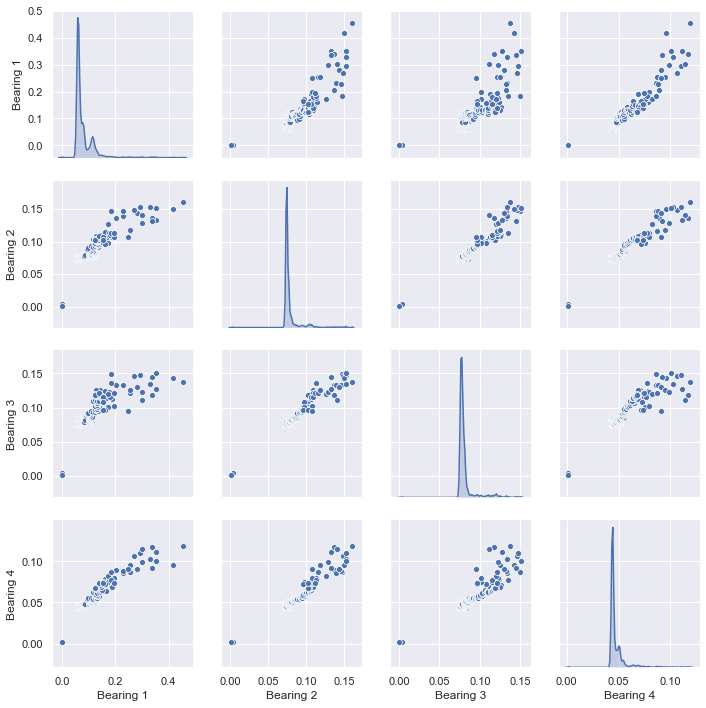

In [13]:
plt.figure();
sns.pairplot(data=merged_data,diag_kind='kde', palette='deep');

Let's look at lag plots to identify autocorrelation and randomness in the data

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

<Figure size 432x288 with 0 Axes>

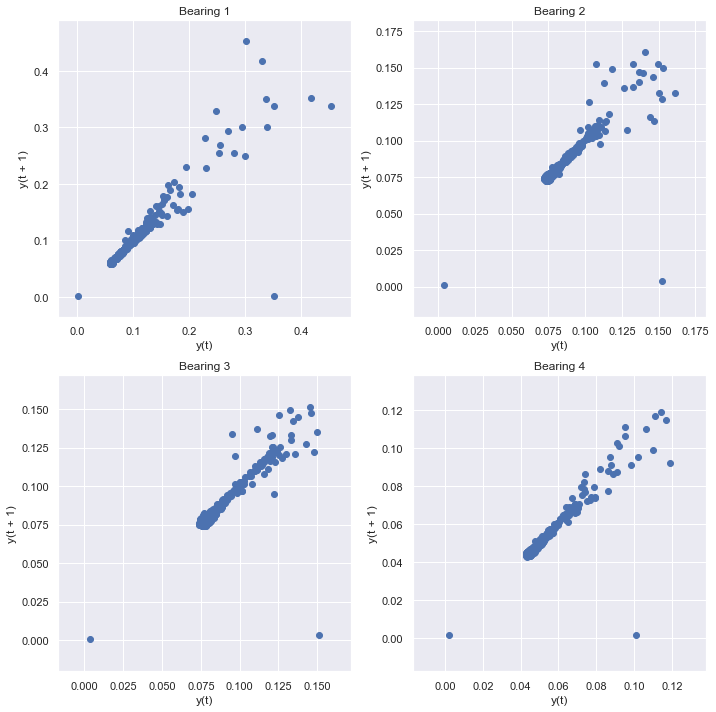

In [255]:
plt.figure();
f,axes=plt.subplots(2,2, figsize=(10,10));
lag_plot(merged_data['Bearing 1'],ax=axes[0,0]);
axes[0,0].title.set_text('Bearing 1');

lag_plot(merged_data['Bearing 2'],ax=axes[0,1]);
axes[0,1].title.set_text('Bearing 2');

lag_plot(merged_data['Bearing 3'],ax=axes[1,0]);
axes[1,0].title.set_text('Bearing 3');

lag_plot(merged_data['Bearing 4'],ax=axes[1,1]);
axes[1,1].title.set_text('Bearing 4');

plt.tight_layout();

From the lag plots above, we learn that the data is non-random, it comes from an underlying autoregressive model with strong positive autocorrelation and that there are a few outliers. We observe that Bearing 1 values are a bit more spread out than all others, this indicates that Bearing 1 deviates the most from the underlying autoregressive model.  

One way to identify outliers would be to identify the parameters ofthe autoregression model. Forecast each time series value using the model and compare that against the true value, if the difference is beyond a certain threshold we identify it as anomalous. This is just an aside, we do not try forecasting for anomaly detection in this notebook.

#### AutoCorrelation and Partial AutoCorrelation

Autocorrelation plots are a commonly-used tool for checking randomness in a data set. This randomness is ascertained by computing autocorrelations for data values at varying time lags. If random, such autocorrelations should be near zero for any and all time-lag separations. If non-random, then one or more of the autocorrelations will be significantly non-zero.

Autocorrelation plots are formed by

Vertical axis: Autocorrelation coefficient
        Rh=Ch/C0
where Ch is the autocovariance function and C0 is the variance function
Note that Rh is between -1 and +1.

Horizontal axis: Time lag h (h = 1, 2, 3, ...)

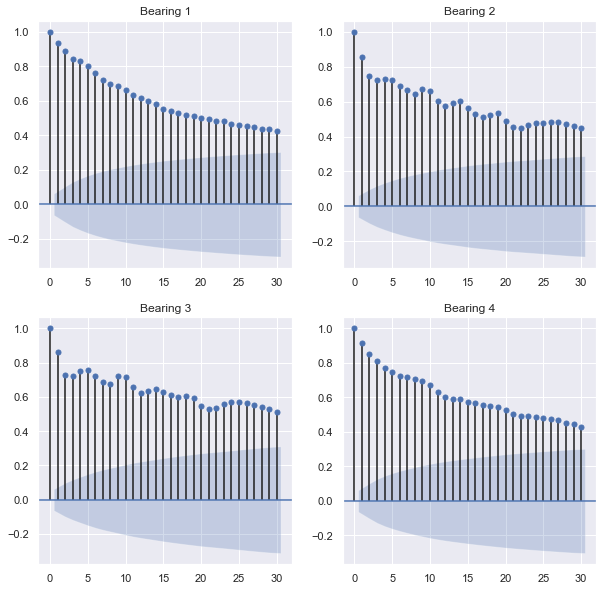

In [164]:
from statsmodels.graphics.tsaplots import plot_acf
f,axes=plt.subplots(2,2, figsize=(10,10));
plot_acf(merged_data['Bearing 1'],title='Bearing 1', ax=axes[0,0]);
plot_acf(merged_data['Bearing 2'],title='Bearing 2', ax=axes[0,1]);
plot_acf(merged_data['Bearing 3'],title='Bearing 3', ax=axes[1,0]);
plot_acf(merged_data['Bearing 4'],title='Bearing 4', ax=axes[1,1]);

We can make the following conclusion: The data come from an underlying autoregressive model with strong positive autocorrelation.
The decreasing autocorrelation is generally linear with little noise. Such a pattern is the autocorrelation plot signature of "strong autocorrelation", which in turn provides high predictability if modeled properly.

The partial autocorrelation at lag k is the autocorrelation between Xt and Xt−k that is not accounted for by lags 1 through k−1.

Specifically, partial autocorrelations are useful in identifying the order of an autoregressive model. The partial autocorrelation of an AR(p) process is zero at lag p+1 and greater. If the sample autocorrelation plot indicates that an AR model may be appropriate, then the sample partial autocorrelation plot is examined to help identify the order. We look for the point on the plot where the partial autocorrelations essentially become zero.

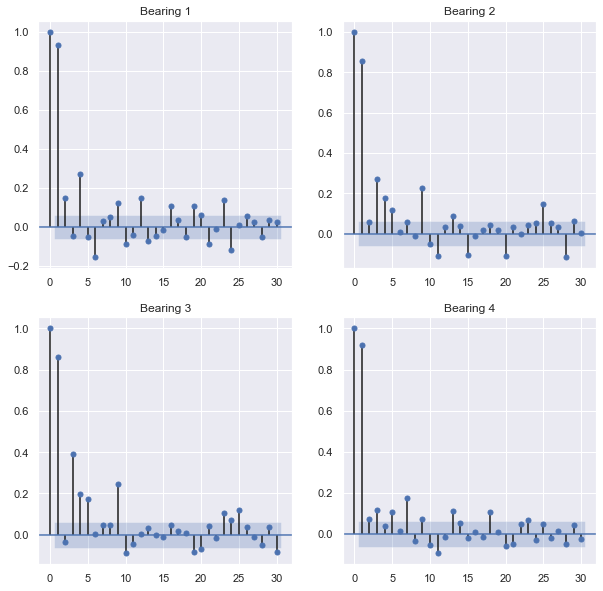

In [180]:
from statsmodels.graphics.tsaplots import plot_pacf
f,axes=plt.subplots(2,2, figsize=(10,10));
plot_pacf(merged_data['Bearing 1'],title='Bearing 1', ax=axes[0,0]);
plot_pacf(merged_data['Bearing 2'],title='Bearing 2', ax=axes[0,1]);
plot_pacf(merged_data['Bearing 3'],title='Bearing 3', ax=axes[1,0]);
plot_pacf(merged_data['Bearing 4'],title='Bearing 4', ax=axes[1,1]);

The above plots show clear statistical significance for lag 1 (lag 0 is always 1). The next most significant lag is 3. If we are to fit an AR model, we could start our modeling with an AR(1) model. We might compare this with an AR(3) model.

In this notebook, we do not perform autoregression. 

#### Statistical tests to check for stationarity

In [6]:
# Check stationarity using Coint_Johansen statistical test for Multivariate time series data
# If Eigenvalues are less than 1, we have a stationary time series 
coint_johansen(merged_data,-1,1).eig

array([0.26248795, 0.16978299, 0.02324282, 0.00154028])

This statistical test proves that each series is stationary. Before we proceed to model building phase, lets confirm stationarity by applying the ADF test to each time series individually. 

In [204]:
result = adfuller(merged_data['Bearing 1'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: 0.8943606798055009
p-value: 0.9930162886000763
Critial Values:
   1%, -3.4371729482129885
Critial Values:
   5%, -2.8645522259969534
Critial Values:
   10%, -2.568373874086242


Since ADF statistic is > critical values, we fail to reject the null hypothesis and the series is non-stationary. This is in contrast to the coint_johansen test. Lets apply differencing to the data to remove trend and then check again for stationarity.

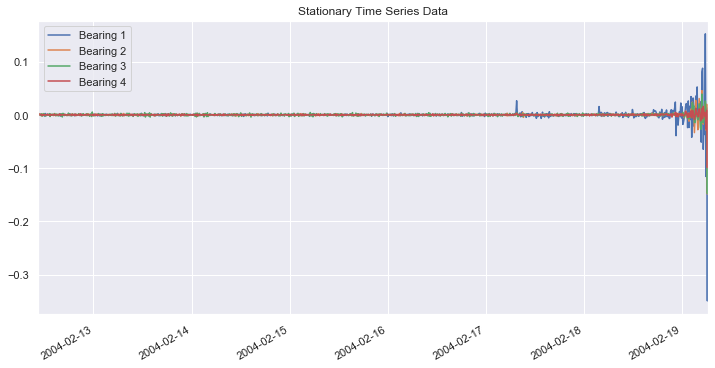

In [256]:
# We difference the data to remove trend and then plot
diff_df=merged_data.diff()
plt.figure(figsize=(12,6));
for col in diff_df.columns:
    diff_df.iloc[:][col].plot();
plt.title('Stationary Time Series')
plt.legend();

In [212]:
result = adfuller(diff_df[1:]['Bearing 1'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -10.25934055745879
p-value: 4.277377427960337e-18
Critial Values:
   1%, -3.4371729482129885
Critial Values:
   5%, -2.8645522259969534
Critial Values:
   10%, -2.568373874086242


Now, our data is stationary as ADF Statistic is less than the critical values. Let's move on to the model building phase.

## Model Building

In [200]:
def visualize_anomalies(scored,cols,score,n_color='blue',a_color='red'):   
    '''
    Helper function to visualize time series with anomalies
    '''
    fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,10))
    a = scored.loc[scored['Anomaly'] == score, cols]

    ax1.plot(scored.index,scored[cols[0]], color=n_color, label = 'Normal')
    ax1.scatter(a.index,a[cols[0]], color=a_color, label = 'Anomaly')
    ax1.title.set_text(cols[0])
    ax1.set_xticklabels(scored.index, rotation=45)
    ax1.legend()
    
    ax2.plot(scored.index,scored[cols[1]], color=n_color, label = 'Normal')
    ax2.scatter(a.index,a[cols[1]], color=a_color, label = 'Anomaly')
    ax2.title.set_text(cols[1])
    ax2.set_xticklabels(scored.index, rotation=45)
    ax2.legend()
    
    ax3.plot(scored.index,scored[cols[2]], color=n_color, label = 'Normal')
    ax3.scatter(a.index,a[cols[2]], color=a_color, label = 'Anomaly')
    ax3.title.set_text(cols[2])
    ax3.legend()
    ax3.set_xticklabels(scored.index, rotation=45)


    ax4.plot(scored.index,scored[cols[3]], color=n_color, label = 'Normal')
    ax4.scatter(a.index,a[cols[3]], color=a_color, label = 'Anomaly')
    ax4.title.set_text(cols[3])
    ax4.legend()
    ax4.set_xticklabels(scored.index, rotation=45)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Before setting up the model, we need to define train/test data. To do this, we perform a simple split where we train on the first part of the dataset (which should represent normal operating conditions), and test on the remaining parts of the dataset leading up to the bearing failure.

In [254]:
#Split the data into train and test.Visualize the training data.
dataset_train = merged_data['2004-02-12 11:02:39':'2004-02-13 23:52:39']
dataset_test = merged_data['2004-02-13 23:52:39':]
#dataset_train.plot(figsize = (12,6))

We then scale the input variables of the model using “MinMaxScaler” which simply re-scales the data to be in the range [0,1].

In [241]:
scaler = preprocessing.MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(dataset_train), 
                              columns=dataset_train.columns, 
                              index=dataset_train.index)
# Random shuffle training data
X_train.sample(frac=1)

X_test = pd.DataFrame(scaler.transform(dataset_test), 
                             columns=dataset_test.columns, 
                             index=dataset_test.index)
print('Train dataset shape: ', X_train.shape)
print('Test dataset shape: ', X_test.shape)

Train dataset shape:  (222, 4)
Test dataset shape:  (760, 4)


### 1. Isolation Forests

Isolation forests are an unsupervised extension of the popular random forest algorithm. The building blocks of isolation forests are isolation trees with a binary outcome (is/is not an outlier).

When an isolation forest is built, the algorithm splits each individual data point off from all other data points. The easier it is to isolate a single point in space from all other points, the more likely it is an outlier (because it’s far away from all other data points). If a data point is an in-lier, it will be closely surrounded by other data points, and will take more splits to isolate.

In [242]:
scaled_df = pd.DataFrame(scaler.fit_transform(merged_data))
scaled_df.columns=cols
scaled_df.index=diff_df.index
scaled_df.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:32:39,0.126423,0.443462,0.548041,0.352522
2004-02-12 10:42:39,0.127888,0.457029,0.555967,0.365087
2004-02-12 10:52:39,0.130633,0.458408,0.552584,0.364252
2004-02-12 11:02:39,0.133329,0.456021,0.556113,0.369692
2004-02-12 11:12:39,0.133120,0.467033,0.545350,0.370007


In [243]:
from sklearn.ensemble import IsolationForest
outlier_fraction=.12

clf=IsolationForest(n_estimators=100, contamination=outlier_fraction, n_jobs=-1, random_state=42,behaviour='new')
clf.fit(X_train)
pred = clf.predict(scaled_df)
scaled_df['Anomaly']=pred
outliers=scaled_df.loc[scaled_df['Anomaly']==-1]

print('# of anomalies and normal points (here points classified -1 are anomalous):')
print(scaled_df['Anomaly'].value_counts())

# of anomalies and normal points (here points classified -1 are anomalous):
 1    958
-1     26
Name: Anomaly, dtype: int64


In [244]:
scaled_df.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4,Anomaly
2004-02-12 10:32:39,0.126423,0.443462,0.548041,0.352522,1
2004-02-12 10:42:39,0.127888,0.457029,0.555967,0.365087,1
2004-02-12 10:52:39,0.130633,0.458408,0.552584,0.364252,1
2004-02-12 11:02:39,0.133329,0.456021,0.556113,0.369692,1
2004-02-12 11:12:39,0.133120,0.467033,0.545350,0.370007,1


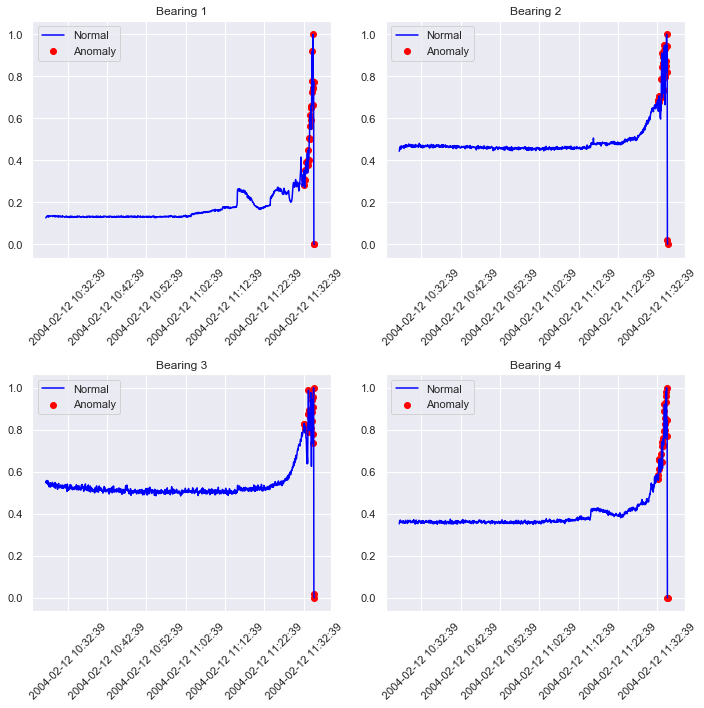

In [245]:
visualize_anomalies(scaled_df,cols,-1)

Anomalies are identified closer to the point of failure of each bearing, whereas data points before that are predicted as normal. This seems a good model for identifing anomalies as not many false positives are detected. Next let's try a neural network based model. 

## 2. AutoEncoders

Next we will use autoencoders to identify anomalies. Using autoencoders, we non-linearly apply dimensionality reduction to our data and then reconstruct the data using a decoder network. The reconstruction loss of the data points is examined to identify anomalous data points. Points that have reconstruciton loss beyond a threshold are termed anomalous. 

Threshold is determined using training and validation data. 

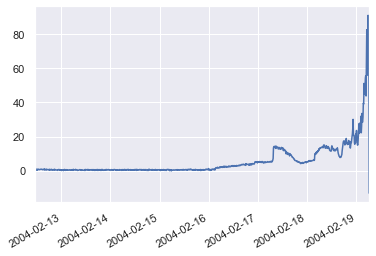

In [101]:
merged_scaled_df = pd.concat([X_train, X_test])
merged_scaled_df.shape
merged_scaled_df['Bearing 1'].plot()

In [220]:
# Model Hyper Parameters
NUM_EPOCHS=100
BATCH_SIZE=10
act_func = 'elu'
kernel_init='glorot_uniform'

In [221]:
# Input layer:
model=Sequential()
# First hidden layer, connected to input vector X. 
model.add(Dense(10, activation=act_func, kernel_initializer=kernel_init,
                kernel_regularizer=regularizers.l2(0.0),
                input_shape=(X_train.shape[1],)))
model.add(Dense(2, activation=act_func, kernel_initializer=kernel_init))
model.add(Dense(10, activation=act_func, kernel_initializer=kernel_init))
model.add(Dense(X_train.shape[1], kernel_initializer=kernel_init))
model.compile(loss='mse',optimizer='adam')

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 10)                50        
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 22        
_________________________________________________________________
dense_18 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_19 (Dense)             (None, 4)                 44        
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


In [222]:
history=model.fit(np.array(X_train),np.array(X_train),
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.05,
                  verbose = 2)

Train on 210 samples, validate on 12 samples
Epoch 1/100
210/210 - 1s - loss: 0.2051 - val_loss: 0.1070
Epoch 2/100
210/210 - 0s - loss: 0.1142 - val_loss: 0.0621
Epoch 3/100
210/210 - 0s - loss: 0.0709 - val_loss: 0.0417
Epoch 4/100
210/210 - 0s - loss: 0.0468 - val_loss: 0.0315
Epoch 5/100
210/210 - 0s - loss: 0.0338 - val_loss: 0.0274
Epoch 6/100
210/210 - 0s - loss: 0.0282 - val_loss: 0.0252
Epoch 7/100
210/210 - 0s - loss: 0.0261 - val_loss: 0.0256
Epoch 8/100
210/210 - 0s - loss: 0.0253 - val_loss: 0.0245
Epoch 9/100
210/210 - 0s - loss: 0.0247 - val_loss: 0.0246
Epoch 10/100
210/210 - 0s - loss: 0.0241 - val_loss: 0.0233
Epoch 11/100
210/210 - 0s - loss: 0.0235 - val_loss: 0.0225
Epoch 12/100
210/210 - 0s - loss: 0.0229 - val_loss: 0.0223
Epoch 13/100
210/210 - 0s - loss: 0.0223 - val_loss: 0.0208
Epoch 14/100
210/210 - 0s - loss: 0.0218 - val_loss: 0.0208
Epoch 15/100
210/210 - 0s - loss: 0.0211 - val_loss: 0.0204
Epoch 16/100
210/210 - 0s - loss: 0.0205 - val_loss: 0.0189
Epoc

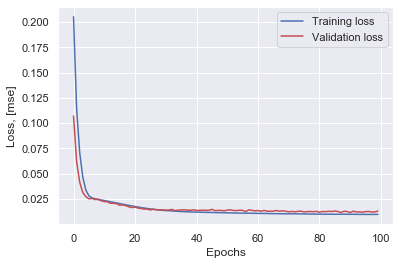

In [223]:
plt.plot(history.history['loss'], 'b',label='Training loss')
plt.plot(history.history['val_loss'], 'r',label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')
plt.show()

Text(0.5, 1.0, 'Distribution of Mean Abs Error Loss')

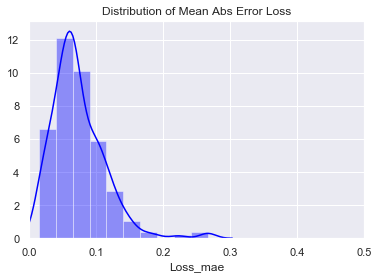

In [225]:
X_pred = model.predict(np.array(X_train))
X_pred = pd.DataFrame(X_pred, 
                      columns=X_train.columns)
X_pred.index = X_train.index

scored = pd.DataFrame(index=X_train.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_train), axis = 1)
plt.figure()
sns.distplot(scored['Loss_mae'],
             bins = 10, 
             kde= True,
             color = 'blue');
plt.xlim([0.0,0.5])
plt.title('Distribution of Mean Abs Error Loss')

From the above loss distribution, let us try a threshold of 0.4 for flagging an anomaly. We can then calculate the loss in the test set, to check when the output crosses the anomaly threshold.

In [226]:
threshold=0.4

In [227]:
merged_scaled_df = pd.concat([X_train, X_test])
preds=model.predict(np.array(merged_scaled_df))
preds = pd.DataFrame(preds, columns=merged_scaled_df.columns)
preds.index = merged_scaled_df.index
preds.head()

scored = pd.DataFrame(index=merged_scaled_df.index)
scored[cols]=merged_scaled_df[cols]
scored['Loss_mae'] = np.mean(np.abs(preds-merged_scaled_df), axis = 1)
scored['Threshold'] = threshold
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4,Loss_mae,Threshold,Anomaly
2004-02-12 11:02:39,0.594640,0.125020,0.953188,0.794650,0.267554,0.4,False
2004-02-12 11:12:39,0.572777,0.515185,0.773329,0.807756,0.121621,0.4,False
2004-02-12 11:22:39,0.642988,0.000000,1.000000,0.472299,0.266854,0.4,False
2004-02-12 11:32:39,0.707427,0.290580,0.749966,0.644737,0.142282,0.4,False
2004-02-12 11:42:39,0.542705,0.197430,0.682892,0.354536,0.131018,0.4,False


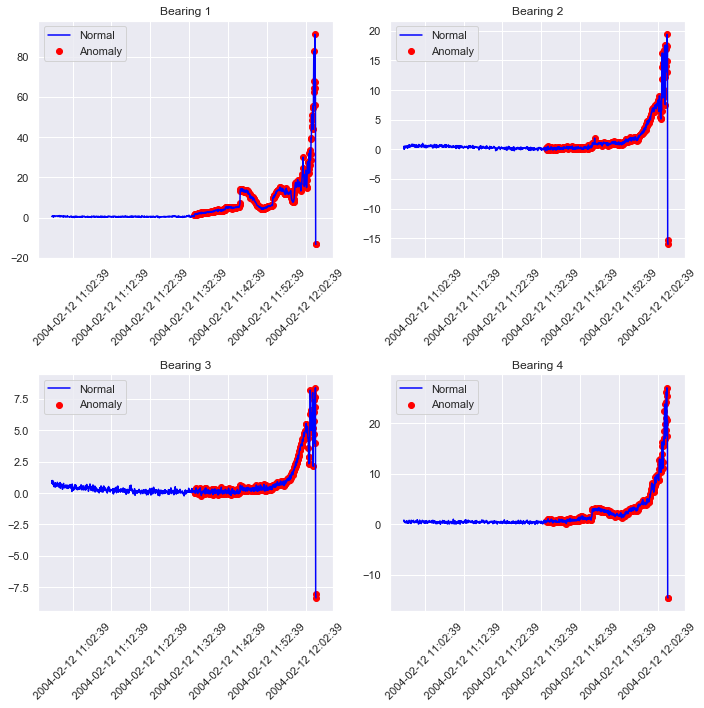

In [228]:
# Visualize Anomalies
visualize_anomalies(scored,cols,True)

We observe that almost all points after 16/02/2004 are marked as anomalous for bearing 1. Though the accelerometer does start to deviate from normal after that point in time, bearings do not fail. These are false positives.

Autoencoder model can be improved by considering more data and improving the model using its hyperparameters. Also adjusting the threshold gives different set of anomalies. 

We note that Isolation forest does better compared to Autoencoders as it provides far fewer false positives. Given more data, autoencoders too can work well in distinguishing normal and anomalous behavior of the bearing.